# CNN with a Trainable Embedding Layer

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
from gensim import utils
import pandas as pd
import pickle

## Compute custom Word2Vec embeddings

In [3]:
NUM_WORDS = 33000
MAXLEN = 5000
DIMS = 300
NGRAM_RANGE = 1

### Functions to do the heavy lifting

In [4]:
def preprocess_corpus(corpus_path, text_column='contents', max_features=33000, maxlen=5000, class_names=[0,1]):
    """
    Takes a corpus of texts stored in a csv file and processes them
    through ktrain's preprocessor in preparation for using them in
    gensim's Word2Vec model.
    """
    preproc = ktrain.text.preprocessor.StandardTextPreprocessor(max_features=max_features,
                                                                maxlen=maxlen,
                                                                class_names=class_names)
    full_corpus = pd.read_csv(corpus_path)
    full_corpus_text = full_corpus[text_column]
    dummy_labels = np.zeros(len(full_corpus_text))
    X, dummy_y = preproc.preprocess_train(full_corpus_text, dummy_labels)
    X = list(X)
    corpus = [preproc.undo(doc).split(' ') for doc in X]
    return preproc, corpus


def build_wv_model(corpus, dims, save_path=None, workers=8):
    """
    Builds, returns, and saves the Word2Vec-like model developed
    from the corpus returned by preprocess_corpus.
    """
    WV = Word2Vec(sentences=corpus, size=dims, workers=8)
    vocab = WV.wv.index2word
    vocab_len = len(vocab)
    embeddings = np.array([WV.wv.get_vector(word) for word in vocab])
    text_to_token = {word: i for word, i in zip(vocab, range(vocab_len))}
    token_to_text = {i: word for word, i in zip(vocab, range(vocab_len))}
    model = {'embeddings': embeddings,
             'text_to_token': text_to_token,
             'token_to_text': token_to_text,
             'vocab': vocab,
             'vocab_len': len(vocab)}
    if save_path is not None:
        with open(save_path, 'wb') as f:
            pickle.dump(model, f)
    return model


def embed_word(word, wv_model, dims):
    if word in wv_model['vocab']:
        token = wv_model['text_to_token'][word]
        return wv_model['embeddings'][token]
    else:
        return np.zeros(dims)
    

def build_embeddings(preproc, wv_model, dims):
    preproc_vocab = preproc.undo(range(NUM_WORDS)).split(' ')
    Embeddings = [embed_word(word, wv_model, dims) for word in preproc_vocab]
    Embeddings = np.stack(Embeddings)
    return(Embeddings)

In [5]:
%%time
preproc, corpus = preprocess_corpus('../data/ICAAD_FIJI.csv', max_features=NUM_WORDS, maxlen=MAXLEN)

language: en
Word Counts: 132011
Nrows: 13384
13384 train sequences
train sequence lengths:
	mean : 2218
	95percentile : 5989
	99percentile : 11259
x_train shape: (13384,5000)
y_train shape: (13384, 1)
Is Multi-Label? False
CPU times: user 4min 11s, sys: 2.45 s, total: 4min 14s
Wall time: 4min 14s


In [6]:
%%time
wv_model = build_wv_model(corpus, DIMS, save_path='./Ioya2Vec/Ioya2Vec.pickle')

CPU times: user 8min 55s, sys: 2.57 s, total: 8min 57s
Wall time: 1min 40s


In [7]:
%%time
Embeddings = build_embeddings(preproc, wv_model, DIMS)

CPU times: user 13.5 s, sys: 23.7 ms, total: 13.5 s
Wall time: 13.5 s


In [8]:
Train = pd.read_csv('../data/train.csv')
x_train = Train.cleaned_contents
y_train = Train.Discrimination_Label

Test = pd.read_csv('../data/test.csv')
x_test = Test.cleaned_contents
y_test = Test.Discrimination_Label

In [9]:
train = preproc.preprocess_test(x_train, y_train)
test = preproc.preprocess_test(x_test, y_test)

647 test sequences
test sequence lengths:
	mean : 1515
	95percentile : 3968
	99percentile : 7513
x_test shape: (647,5000)
y_test shape: (647, 2)
162 test sequences
test sequence lengths:
	mean : 1419
	95percentile : 3336
	99percentile : 7205
x_test shape: (162,5000)
y_test shape: (162, 2)


## Build the model

In [10]:
def _build_cnn(maxlen, max_features, embed_dim, filters, kernels,
               embeddings, dropout=0.1, density=64,
               loss_func='categorical_crossentropy',
               activation = 'softmax', metrics=['accuracy'],
               verbose=1, optimizer='adam'):
    
    embedding_matrix = np.ones((max_features, 1))
    embedding_matrix[0] = 0

    # set up the model
    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(max_features, embed_dim, input_length=maxlen, 
                                  trainable=False)(inp)
    x0 = tf.keras.layers.Conv1D(filters=filters,
                               kernel_size=kernels[0],
                               activation='relu')(x)
    x0 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[0] + 1)(x0)

    x1 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[1],
                                activation='relu')(x)
    x1 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[1] + 1)(x1)
    
    x2 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[2],
                                activation='relu')(x)
    x2 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[2] + 1)(x2)
    
    x3 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[3],
                                activation='relu')(x)
    x3 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[3] + 1)(x3)

    x4 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[4],
                                activation='relu')(x)
    x4 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[4] + 1)(x4)

    x = tf.keras.layers.concatenate([x0, x1, x2, x3, x4])

    x = tf.keras.layers.Dense(density, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(2, activation=activation)(x)
    model = tf.keras.Model(inputs=inp, outputs=outputs)
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=metrics)
    
    model.layers[1].set_weights([embeddings])
    
    return model

In [11]:
model = _build_cnn(MAXLEN, len(Embeddings), DIMS, filters=32, kernels=[2, 3, 4, 5, 6], embeddings=Embeddings, dropout=0.4, density=64)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

In [12]:
learner.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 300)    9899700     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4999, 32)     19232       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4998, 32)     28832       embedding[0][0]                  
______________________________________________________________________________________________

## Make sure the pre-trained embeddings are there

In [13]:
learner.model.weights[0]

<tf.Variable 'embedding/embeddings:0' shape=(32999, 300) dtype=float32, numpy=
array([[-1.1520541e+00,  7.2150491e-02, -1.7403871e-01, ...,
         1.6726202e-01,  5.6497478e-01, -1.2624184e+00],
       [-3.8660410e-01, -1.3689015e+00, -4.3510160e-01, ...,
        -5.0173438e-01, -9.2810102e-02,  1.3866685e-01],
       [-1.3284112e+00,  5.7827443e-01,  1.3908583e+00, ...,
        -1.0364702e+00, -1.4521101e+00, -1.5458256e+00],
       ...,
       [ 4.1151270e-02, -9.7989710e-03,  8.5672781e-02, ...,
        -1.9796930e-02, -3.8129922e-02,  1.6541569e-02],
       [ 3.9302524e-02, -1.8394027e-04,  9.2655078e-02, ...,
        -9.6405528e-02, -2.1883627e-02,  3.9890978e-02],
       [ 3.1637993e-02, -7.8979857e-02, -6.1173894e-02, ...,
         1.3802289e-02, -3.4805153e-02, -6.4080976e-02]], dtype=float32)>

In [14]:
Embeddings

array([[-1.15205407e+00,  7.21504912e-02, -1.74038708e-01, ...,
         1.67262018e-01,  5.64974785e-01, -1.26241839e+00],
       [-3.86604100e-01, -1.36890149e+00, -4.35101599e-01, ...,
        -5.01734376e-01, -9.28101018e-02,  1.38666853e-01],
       [-1.32841122e+00,  5.78274429e-01,  1.39085829e+00, ...,
        -1.03647017e+00, -1.45211005e+00, -1.54582560e+00],
       ...,
       [ 4.11512703e-02, -9.79897100e-03,  8.56727809e-02, ...,
        -1.97969303e-02, -3.81299220e-02,  1.65415686e-02],
       [ 3.93025242e-02, -1.83940268e-04,  9.26550776e-02, ...,
        -9.64055285e-02, -2.18836274e-02,  3.98909785e-02],
       [ 3.16379927e-02, -7.89798573e-02, -6.11738935e-02, ...,
         1.38022890e-02, -3.48051526e-02, -6.40809759e-02]])

## Define and train the model

### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

simulating training for different learning rates... this may take a few moments...
Train on 647 samples
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


647/647 [==============================] - 6s 9ms/sample - loss: 6.2529 - accuracy: 0.4420
Epoch 2/5
647/647 [==============================] - 3s 4ms/sample - loss: 5.5156 - accuracy: 0.4544
Epoch 3/5
647/647 [==============================] - 3s 4ms/sample - loss: 2.8733 - accuracy: 0.5410
Epoch 4/5
647/647 [==============================] - 3s 4ms/sample - loss: 5.2979 - accuracy: 0.5657
Epoch 5/5
256/647 [==========>...................] - ETA: 1s - loss: 420.2207 - accuracy: 0.6016

done.
Visually inspect loss plot and select learning rate associated with falling loss


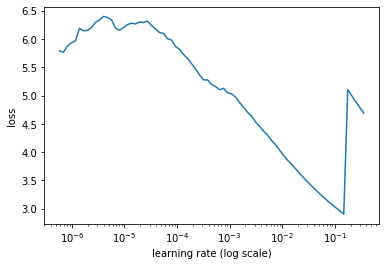

In [15]:
learner.lr_find(show_plot=True)

### Train

In [16]:
learner.autofit(10e-3, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 7ms/sample - loss: 2.7444 - accuracy: 0.5286 - val_loss: 0.6599 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6675 - accuracy: 0.5951 - val_loss: 0.6760 - val_accuracy: 0.6111
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6749 - accuracy: 0.5889 - val_loss: 0.6598 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6522 - accuracy: 0.5719 - val_loss: 0.6603 - val_accuracy: 0.5988
Epoch 5/1024
640/647 [============================>.] - ETA: 0s - loss: 0.6572 - accuracy: 0.5703
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 0.005 (if not early_stopping).
647/647 [==============================] - 3s 5ms

## Examine results

In [17]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.57      0.35      0.44        65
           1       0.66      0.82      0.73        97

    accuracy                           0.64       162
   macro avg       0.62      0.59      0.58       162
weighted avg       0.62      0.64      0.61       162



array([[23, 42],
       [17, 80]])

## Explain a prediction

In [18]:
import pandas as pd
X_test = pd.read_csv('../data/test.csv')['cleaned_contents']

In [25]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [35]:
y_hat = predictor.predict(list(x_test))

In [37]:
(y_hat == y_test).sum()

113

In [43]:
predictor.predict("The accused is the sole breadwinner for his family and is involved in his church community.")

1

In [45]:
learner.evaluate(test)

              precision    recall  f1-score   support

           0       0.65      0.54      0.59        65
           1       0.72      0.80      0.76        97

    accuracy                           0.70       162
   macro avg       0.69      0.67      0.67       162
weighted avg       0.69      0.70      0.69       162



array([[35, 30],
       [19, 78]])

In [63]:
Embeddings

array([[-0.95571923,  0.80129987, -1.45219648, ...,  1.01454258,
         1.77791834, -0.66057944],
       [-0.73984241,  1.00298786,  0.94306082, ...,  0.48449713,
         0.55874068,  1.96365499],
       [-0.20715149,  2.01718593, -0.32258588, ..., -0.22842658,
         1.26604187, -0.05658771],
       ...,
       [-0.05113932,  0.00685608,  0.00228031, ...,  0.04837001,
         0.00929243, -0.00382673],
       [ 0.02422185, -0.04101824, -0.03618522, ...,  0.02189103,
         0.02863402, -0.02953816],
       [-0.01571665,  0.0836259 ,  0.0910797 , ...,  0.03493011,
         0.01273112, -0.01555377]])

In [66]:
Embeddings.shape

(32999, 300)

In [67]:
from sklearn.metrics.pairwise import cosine_similarity

In [125]:
wv_model['text_to_token']['suva']

127

In [126]:
preproc.tok.texts_to_sequences(['suva'])

[[128]]

In [123]:
cosine_similarity(Embeddings[565,:].reshape(1,-1), Embeddings).argsort()

array([[ 7878, 16630, 14127, ..., 18232,  4642,   565]])

In [124]:
preproc.tok.sequences_to_texts([[4642]])

['suggesting']

In [130]:
{preproc.tok.texts_to_sequences([word]) : word for word in wv_model['vocab']}

TypeError: unhashable type: 'list'

In [140]:
embed_dict = {preproc.tok.texts_to_sequences([word])[0][0] : word for word in wv_model['vocab']}

In [190]:
preproc.tok.texts_to_sequences(['rape'])

[[593]]

In [191]:
embed_dict[593]

'rape'

In [192]:
preproc.tok.sequences_to_texts([[593]])

['rape']

In [146]:
Embeddings = np.stack([embed_word(preproc.tok.sequences_to_texts([[i]])[0], wv_model, 300) for i in range (1, 33000)])

In [196]:
Embeddings.shape

(32999, 300)

In [198]:
Embeddings = np.concatenate((np.zeros(300).reshape(1,-1), Embeddings))

In [210]:
learner.reset_weights()

Model weights have been reset.


In [211]:
learner.model.weights[0]

<tf.Variable 'embedding_4/embeddings:0' shape=(32999, 300) dtype=float32, numpy=
array([[-0.95571923,  0.80129987, -1.4521965 , ...,  1.0145426 ,
         1.7779183 , -0.66057944],
       [-0.7398424 ,  1.0029879 ,  0.9430608 , ...,  0.48449713,
         0.5587407 ,  1.963655  ],
       [-0.20715149,  2.017186  , -0.32258588, ..., -0.22842658,
         1.2660419 , -0.05658771],
       ...,
       [-0.05113932,  0.00685608,  0.00228031, ...,  0.04837001,
         0.00929243, -0.00382673],
       [ 0.02422185, -0.04101824, -0.03618522, ...,  0.02189103,
         0.02863402, -0.02953816],
       [-0.01571665,  0.0836259 ,  0.0910797 , ...,  0.03493011,
         0.01273112, -0.01555377]], dtype=float32)>

In [217]:
Embeddings.shape

(33000, 300)

In [218]:
learner.model.weights[0] = Embeddings[:-1]

In [301]:
model = _build_cnn(MAXLEN, len(Embeddings), DIMS, filters=32, kernels=[2, 3, 4, 5, 6], embeddings=Embeddings, dropout=0.1, density=64, loss_func='binary_crossentropy',)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

In [302]:
learner.model.weights[0]

<tf.Variable 'embedding_15/embeddings:0' shape=(33000, 300) dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.95571923,  0.80129987, -1.4521965 , ...,  1.0145426 ,
         1.7779183 , -0.66057944],
       [-0.7398424 ,  1.0029879 ,  0.9430608 , ...,  0.48449713,
         0.5587407 ,  1.963655  ],
       ...,
       [-0.05113932,  0.00685608,  0.00228031, ...,  0.04837001,
         0.00929243, -0.00382673],
       [ 0.02422185, -0.04101824, -0.03618522, ...,  0.02189103,
         0.02863402, -0.02953816],
       [-0.01571665,  0.0836259 ,  0.0910797 , ...,  0.03493011,
         0.01273112, -0.01555377]], dtype=float32)>

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


Train on 647 samples
Epoch 1/5
647/647 [==============================] - 5s 7ms/sample - loss: 1.8140 - accuracy: 0.5626
Epoch 2/5
647/647 [==============================] - 4s 5ms/sample - loss: 1.6460 - accuracy: 0.5317
Epoch 3/5
647/647 [==============================] - 4s 5ms/sample - loss: 1.2638 - accuracy: 0.5425
Epoch 4/5
647/647 [==============================] - 4s 6ms/sample - loss: 2.5898 - accuracy: 0.5533
Epoch 5/5
647/647 [==============================] - 4s 6ms/sample - loss: 7.5969 - accuracy: 0.4869


done.
Visually inspect loss plot and select learning rate associated with falling loss


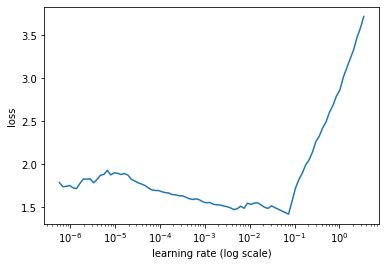

In [303]:
learner.lr_find(show_plot=True)

In [304]:
learner.autofit(10e-3)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 5s 8ms/sample - loss: 2.4335 - accuracy: 0.5549 - val_loss: 1.1787 - val_accuracy: 0.3951
Epoch 2/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.8704 - accuracy: 0.5240 - val_loss: 0.7714 - val_accuracy: 0.4074
Epoch 3/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6915 - accuracy: 0.5595 - val_loss: 0.6673 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6617 - accuracy: 0.5734 - val_loss: 0.6796 - val_accuracy: 0.5988
Epoch 5/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6675 - accuracy: 0.5951 - val_loss: 0.6531 - val_accuracy: 0.6111
Epoch 6/1024
647/647 [===================

In [305]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [306]:
y_hat = predictor.predict(list(x_test))

In [307]:
y_HAT = np.array([i[1][1] > i[0][1] for i in y_hat])

In [325]:
TP = ((y_HAT == True) & (y_test == 1)).sum()

In [326]:
TP

70

In [310]:
FN = ((y_HAT == False) & (y_test == 1)).sum()

In [311]:
FN

27

In [312]:
FP = ((y_HAT == True) & (y_test == 0)).sum()

In [313]:
FP

17

In [327]:
2*TP/(2*TP + FN + FP)

0.7608695652173914

In [329]:
(y_HAT == y_test).sum() / len(y_test)

0.7283950617283951

In [330]:
TP / (TP + FP)

0.8045977011494253

In [331]:
TP / (TP + FN)

0.7216494845360825

In [323]:
TN = len(y_hat) - TP - FN - FP

In [324]:
TN

0

In [332]:
learner.save_model('cnn_Ioya2Vec_model')

In [333]:
tf.keras.models.save_model(model, filepath='./cnn_Ioya2Vec_model')

In [334]:
predictor.save('cnn_Ioya2Vec_predictor')